# Astronomaly

This notebook is designed to replicate the feature extraction methods of Astronomaly. In addition, the steps are shown individually and explained in order to provide better detail in the processes of Astronomaly. The notebook would thus ideally serve as a troubleshooting method for Astronomaly.

## Using A Sample From Astronomaly

This section displays the contours and ellipses found by Astronomaly. The image within this section is taken directly from Astronomaly and the contours and ellipses are shown for this image. The image has already been transformed before it is obtained and as such the separate transformations can not be displayed here.

__________________________

In [1]:
from astronomaly.anomaly_detection import isolation_forest, human_loop_learning
from astronomaly.base import logging_tools
from astronomaly.base.base_pipeline import PipelineStage
from astronomaly.data_management import image_reader
from astronomaly.dimensionality_reduction import pca
from astronomaly.feature_extraction import power_spectrum, autoencoder, shape_features
from astronomaly.feature_extraction.shape_features import find_contours, fit_ellipse, draw_contour
from astronomaly.feature_extraction.shape_features import get_ellipse_leastsq, extract_contour
from astronomaly.postprocessing import scaling
from astronomaly.preprocessing import image_preprocessing
from astronomaly.preprocessing.image_preprocessing import image_transform_sigma_clipping, image_transform_scale, image_transform_greyscale
from astronomaly.visualisation import tsne
from astronomaly.utils import utils

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

%matplotlib inline

_______________________

### Setting up the data

#### This subsection contains all of the relevant data and parameters that are to be specified in order for Astronomaly to run. 

Selecting the data brick to be used:

In [2]:
coadd_id = '0260'  # Brick code

Selecting the transform functions

In [3]:
image_transform_function = [image_preprocessing.image_transform_scale,
                            image_preprocessing.image_transform_greyscale,
                            image_preprocessing.image_transform_sigma_clipping,
                            image_preprocessing.image_transform_scale,
                            ]

display_transform_function = [image_preprocessing.image_transform_scale
]

The data directory can be set up to shorten other directories and assists in sorting out the data storage. Due to the large number of bricks involved, it is much simpler to merely change the brick name than the entire directory all the time

In [4]:
data_dir = '/home/verlon/Desktop/Astronomaly/Data/Coadd_'+str(coadd_id)+'/'

In [5]:
image_dir = os.path.join(data_dir, '0260m062', 'Input', 'Images')
output_dir = os.path.join(data_dir, '0260m062', 'Output', '')

In [6]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Selecting the catalogue (as created by the convert_tractor_catalogue function in utils.py)

In [7]:
catalogue = pd.read_csv(os.path.join(
    data_dir, '0260m062', 'Input','Catalogue', 'test_catalogue_0260m062_500.csv'))

________________________________________

## Running Astronomaly

This is how Astronomaly can be run in a notebook, similar as to how it can be called in the *image_pipeline* script. This is required to obtain a sample cutout from the dataset.

Running the cell shows which fits files are read in and used as well as how many objects are found in the catalogue.

In [8]:
feature_method = 'ellipse'
dim_reduction = ''

image_dataset = image_reader.ImageDataset(directory=image_dir,
                                          list_of_files=[],
                                          window_size=32,
                                          output_dir=output_dir,
                                          plot_square=False,
                                          transform_function=[],
                                          display_transform_function=display_transform_function,
                                          plot_cmap='hot',
                                          catalogue=catalogue,
                                          band_prefixes=['z-', 'r-', 'g-'],
                                          bands_rgb={'r': 'z-', 'g': 'r-', 'b': 'g-'}
                                         )

Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0260/0260m062/Input/Images/z-legacysurvey-0260m062-image.fits.fz...


2020-11-04 12:29:08,521 - WARNING - FITSFixedWarning: 'datfix' made the change 'Set DATE-REF to '1858-11-17' from MJD-REF'.


Done!
A catalogue of  500 sources has been provided.


__________________________

This is where a sample is selected and it has yet to be transformed. To see the indices applicable, use :  *image_dataset.metadata.index*

In [9]:
source_ind = '432'

______________

### Original Image

This is the image as returned by the *get_sample* function. This image is cutout from the fits files directly and is unchanged at this stage. 

In [10]:
image_original = image_dataset.get_sample(source_ind)

2020-11-04 12:29:09,129 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 31.5, 31.5, -0.5)

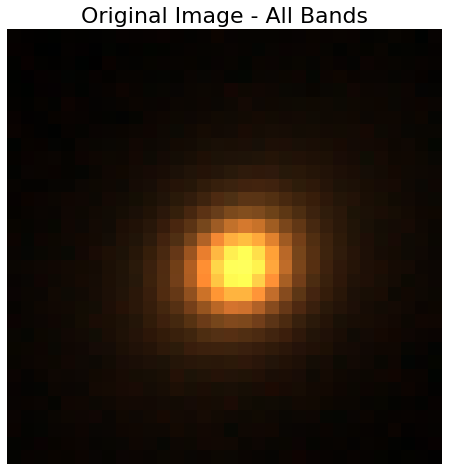

In [11]:
plt.figure(figsize=(8, 8))
plt.title('Original Image - All Bands', fontsize=22)
plt.imshow(image_original)
plt.axis('off')

____________________

## Applying The Image Transformation Functions

### First Scale Transform

The Scale Transfrom function rescales the values of the array so that they lie between 0 and 1. This is also the first scale transform applied (hence first scale transform) and is applied on each channel individually. This simplifies further proceedings. Again, the individual bands are displayed below for informational purposes.

In [12]:
image_transform_one = image_transform_scale(image_original)

(-0.5, 31.5, 31.5, -0.5)

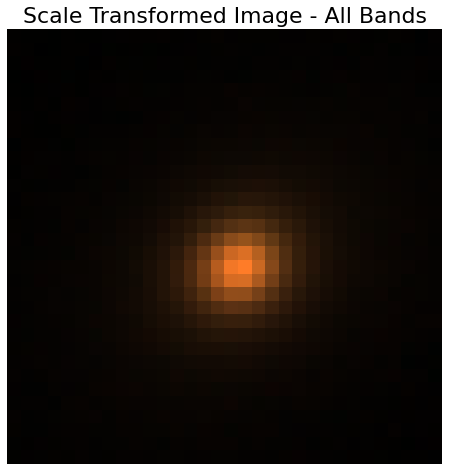

In [13]:
plt.figure(figsize=(8, 8))
plt.title('Scale Transformed Image - All Bands', fontsize=22)
plt.imshow(image_transform_one)
plt.axis('off')

______________

### Greyscale Image

The Greyscale function uses OpenCvs colour converter to convert each separate image channel to a specific colour. The channels are then combined to create a single channel image that is *greyscale* and contains information from all three separate bands. This allows more information to be used compared to using a single channel only.

In [14]:
image_grey = cv2.cvtColor(image_transform_one, cv2.COLOR_BGR2GRAY)

(-0.5, 31.5, 31.5, -0.5)

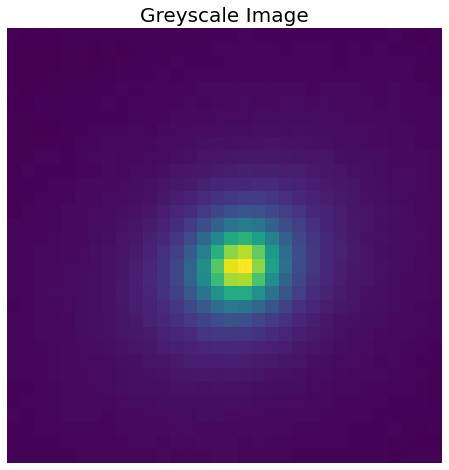

In [15]:
plt.figure(figsize=(8, 8))
plt.title('Greyscale Image', fontsize=20)
plt.imshow(image_grey)
plt.axis('off')

___________________________

### Sigma Clipping

The Sigma Clipping function is used to remove noise surrounding the object in question. It also serves in providing an 'outline' of the object in question. Details of how sigma clipping works are left out of this notebook for simplicity.

In [16]:
image_sigma_clipped = image_transform_sigma_clipping(image_grey)

(-0.5, 31.5, 31.5, -0.5)

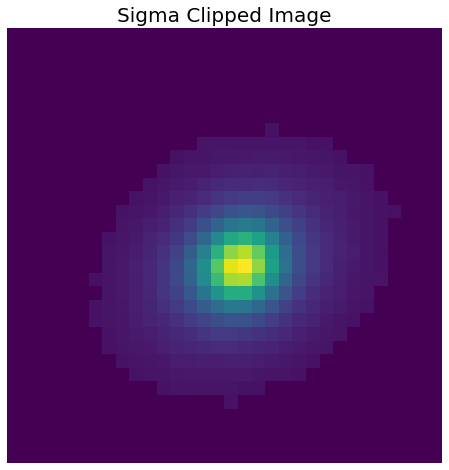

In [17]:
plt.figure(figsize=(8, 8))
plt.title('Sigma Clipped Image', fontsize=20)
plt.imshow(image_sigma_clipped)
plt.axis('off')

______________________

### Second Scale Transform

The function is the same as the first scale transform. It is applied here because the sigma clipping and the greyscale functions change the values of the arrays. This is the final transform applied and it is thus ideal to have the array values between 0 and 1 for machine learning purposes.

In [18]:
image_transform_two = image_transform_scale(image_sigma_clipped)

(-0.5, 31.5, 31.5, -0.5)

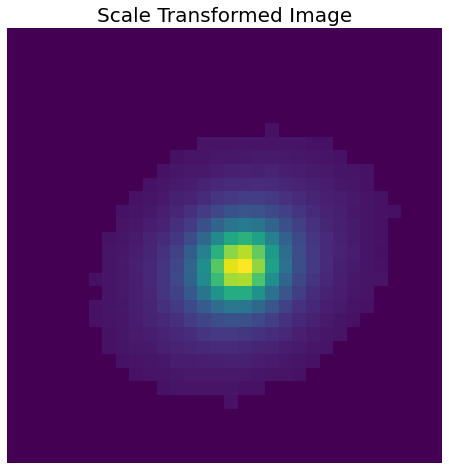

In [19]:
plt.figure(figsize=(8, 8))
plt.title('Scale Transformed Image', fontsize=20)
plt.imshow(image_transform_two)
plt.axis('off')

_____________

### Combined effects

This image shows all of the previous steps one after the other for a sample cutout.

2020-11-04 12:29:11,278 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


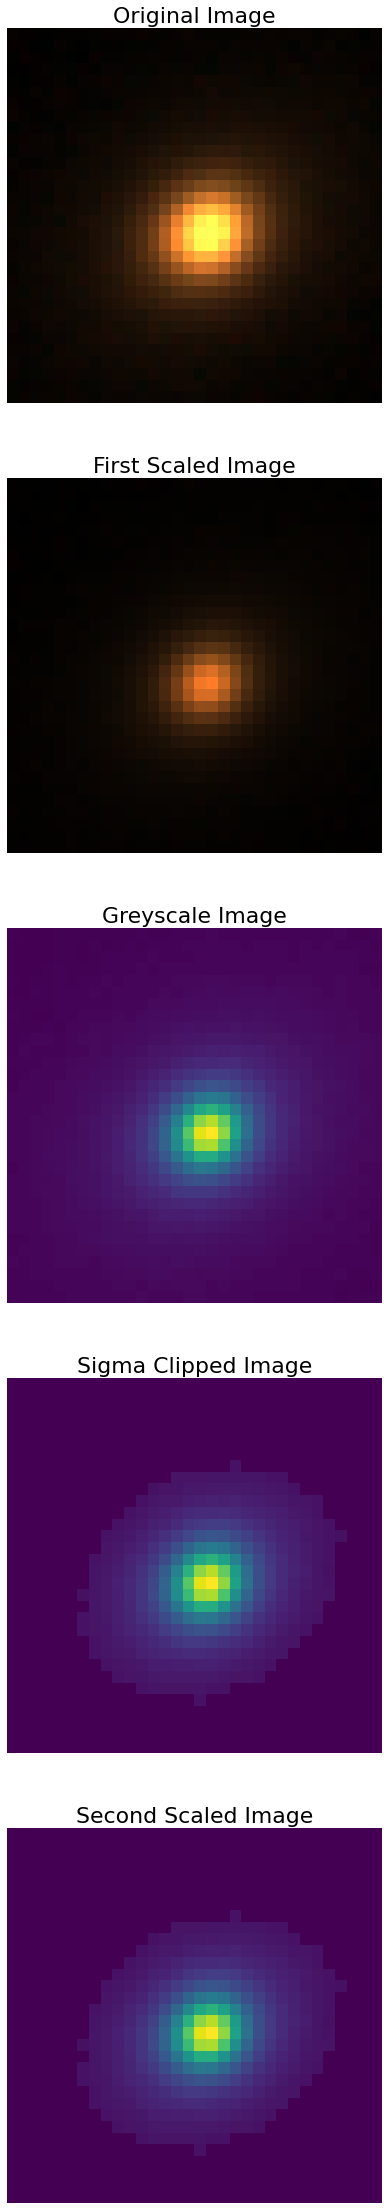

In [20]:
f = plt.figure(figsize=(50, 40))

f.add_subplot(5, 1, 1)
plt.imshow(image_original)
plt.gca().set_title('Original Image', fontsize=22)
plt.axis('off')

f.add_subplot(5, 1, 2)
plt.imshow(image_transform_one)
plt.gca().set_title('First Scaled Image', fontsize=22)
plt.axis('off')

f.add_subplot(5, 1, 3)
plt.imshow(image_grey)
plt.gca().set_title('Greyscale Image', fontsize=22)
plt.axis('off')

f.add_subplot(5, 1, 4)
plt.imshow(image_sigma_clipped)
plt.gca().set_title('Sigma Clipped Image', fontsize=22)
plt.axis('off')

f.add_subplot(5, 1, 5)
plt.imshow(image_transform_two)
plt.gca().set_title('Second Scaled Image', fontsize=22)
plt.axis('off')

plt.show(block=True)

_________________

### Percentiles and Scale Range

Select the percentiles to be used. These percentiles divide the image into regions based on the image array values. It is these percentiles that determine the location of the contours that are to be drawn. The scale range supplied provides the range of scale over which the image can be resampled in order to determine the contours and ellipses.

In [21]:
percentiles = [90, 80, 70, 60, 50, 0]
print('Percentiles Used :', percentiles)
print()

scale = [i for i in np.arange(100, 201, 1)]
print('Scale Range Used : From 100 to 200 in increments of 1%')

Percentiles Used : [90, 80, 70, 60, 50, 0]

Scale Range Used : From 100 to 200 in increments of 1%


___________________

The image dataset has to be rerun with the image transform function applicable in order to correctly display the contours and corresponding ellipses.

In [27]:
feature_method = 'ellipse'
dim_reduction = ''

image_dataset = image_reader.ImageDataset(directory=image_dir,
                                          list_of_files=[],
                                          window_size=32,
                                          output_dir=output_dir,
                                          plot_square=False,
                                          transform_function=image_transform_function,
                                          display_transform_function=display_transform_function,
                                          plot_cmap='hot',
                                          catalogue=catalogue,
                                          band_prefixes=['z-', 'r-', 'g-'],
                                          bands_rgb={'r': 'z-', 'g': 'r-', 'b': 'g-'}
                                         )

Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0260/0260m062/Input/Images/z-legacysurvey-0260m062-image.fits.fz...


2020-11-04 12:30:41,788 - WARNING - FITSFixedWarning: 'datfix' made the change 'Set DATE-REF to '1858-11-17' from MJD-REF'.


Done!
A catalogue of  500 sources has been provided.


This is required so as to display the single source only.

In [28]:
ind = []
ind.append(source_ind)
image_dataset.index = ind

In [29]:
pipeline_ellipse = shape_features.EllipseFitFeatures(
    percentiles=[90, 80, 70, 60, 50, 0],
    output_dir=output_dir, channel=0, force_rerun=True
)

In [30]:
features_original, contours, ellipses = pipeline_ellipse.run_on_dataset(image_dataset)

Extracting features using EllipseFitFeatures ...
0 instances completed
Done! Time taken:  0.020926475524902344 s


#### All of the contours and the correscponding ellipses are plotted here. The cmap is set to hot to better visualise the contours and ellipses.

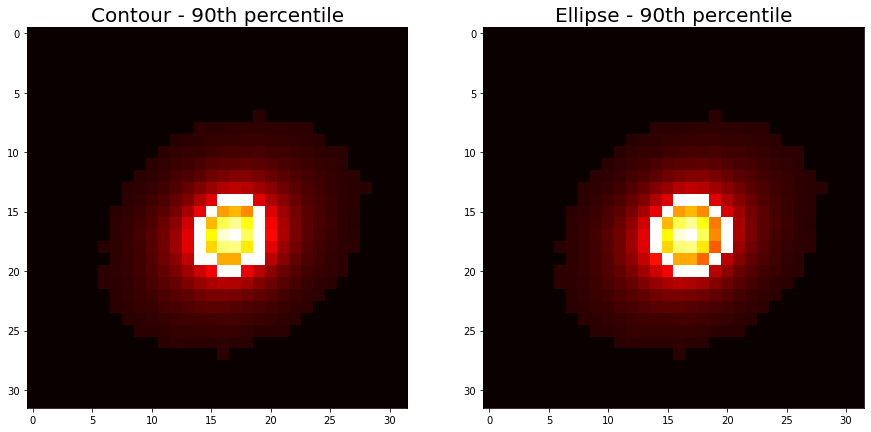

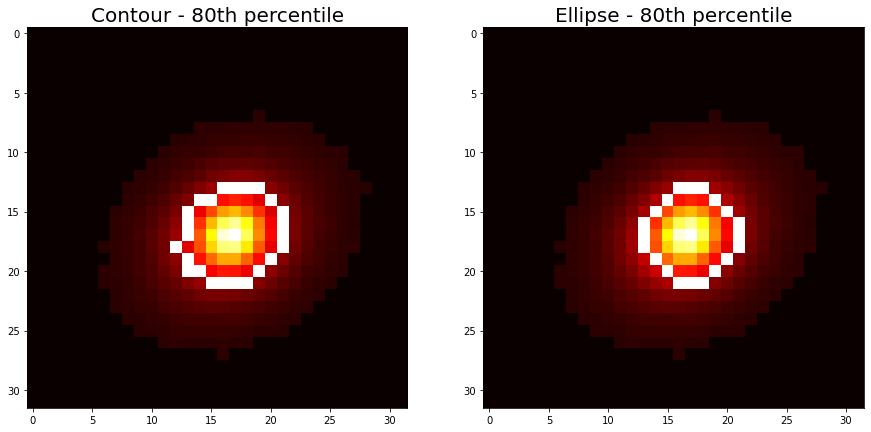

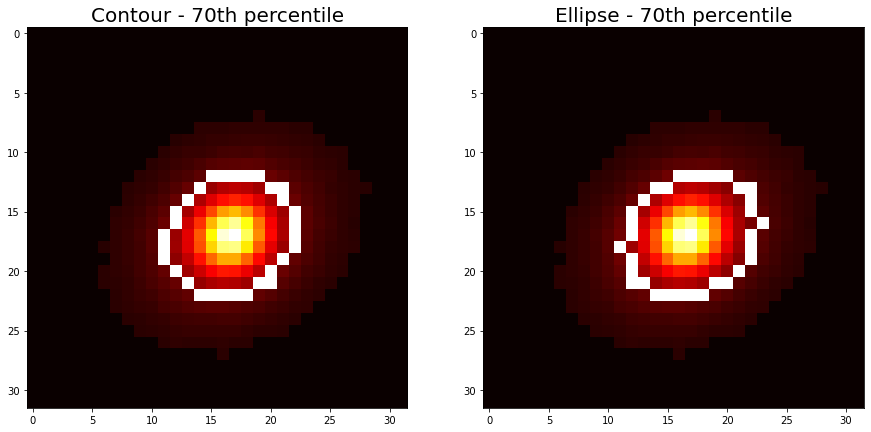

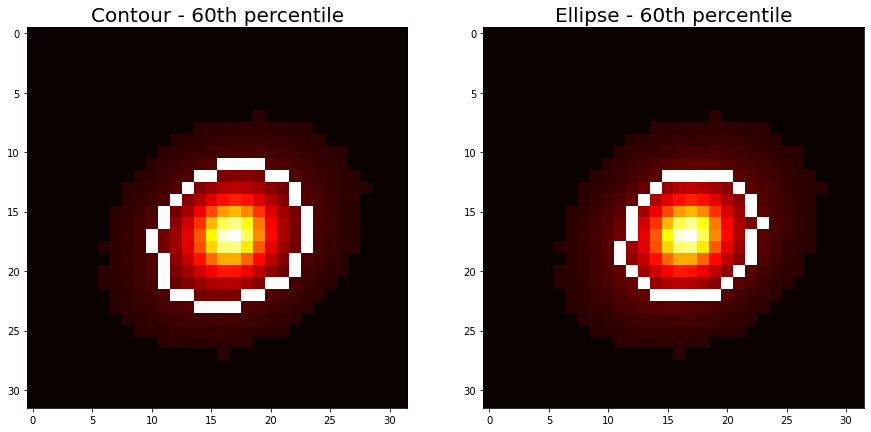

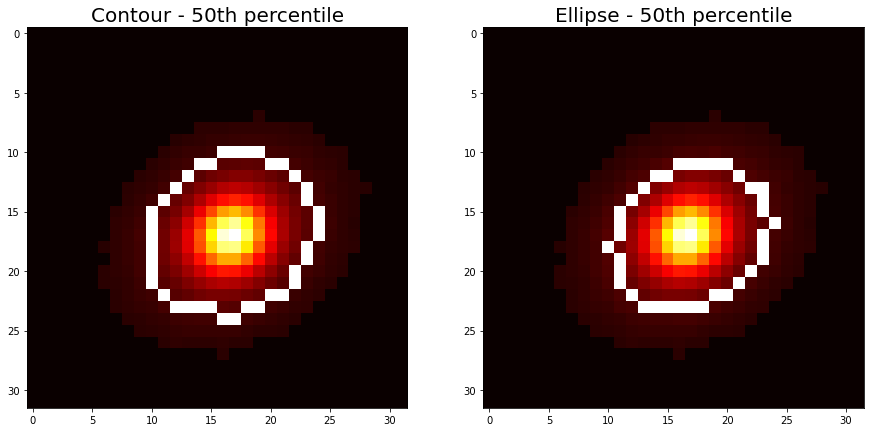

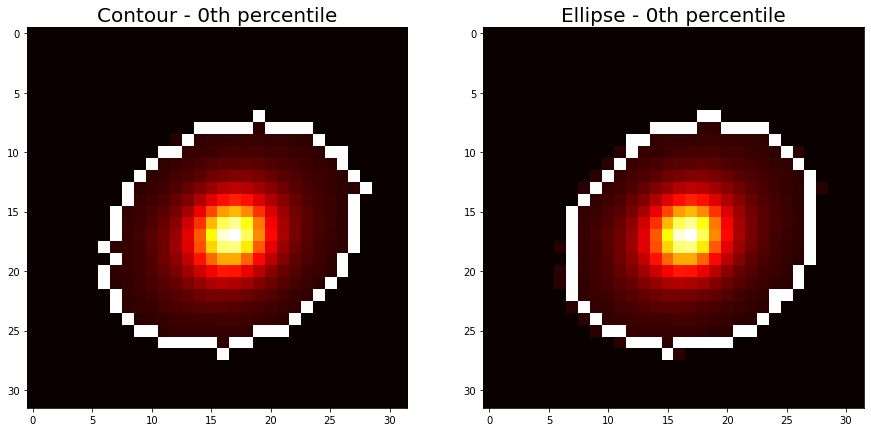

In [31]:
for i in range(len(contours)):
    f = plt.figure(figsize=(15, 15))

    f.add_subplot(1, 2, 1)
    plt.imshow(contours[i], cmap='hot')
    plt.gca().set_title('Contour - ' +
                        str(percentiles[i]) + 'th percentile', fontsize=20)

    f.add_subplot(1, 2, 2)
    plt.imshow(ellipses[i], cmap='hot')
    plt.gca().set_title('Ellipse - ' +
                        str(percentiles[i]) + 'th percentile', fontsize=20)

    plt.show(block=True)

_______________